# Contrast Sensitivity

In [1]:
import sys, os
import numpy as np
import scipy

# physion should be installed with "pip install physion"
import physion
import physion.utils.plot_tools as pt
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

# data folder:
DATA_folder = os.path.join(os.path.expanduser('~'), 'DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/2orient_8contr')

In [2]:
DATASET = physion.analysis.read_NWB.scan_folder_for_NWBfiles(DATA_folder, verbose=False)

In [3]:
for i, f in enumerate(DATASET['files']):
    print('- sessionID %.2d : %s' % (i, os.path.basename(f)))

- sessionID 00 : 2024_03_22-14-35-26.nwb
- sessionID 01 : 2024_04_15-15-03-35.nwb
- sessionID 02 : 2024_04_24-14-50-00.nwb
- sessionID 03 : 2024_04_24-15-46-52.nwb
- sessionID 04 : 2024_04_24-16-52-45.nwb
- sessionID 05 : 2024_04_29-14-45-02.nwb
- sessionID 06 : 2024_04_29-15-36-11.nwb
- sessionID 07 : 2024_05_06-10-27-14.nwb
- sessionID 08 : 2024_05_06-11-20-07.nwb
- sessionID 09 : 2024_05_06-11-49-02.nwb
- sessionID 10 : 2024_05_06-16-57-49.nwb
- sessionID 11 : 2024_05_28-14-44-41.nwb
- sessionID 12 : 2024_05_30-13-51-39.nwb
- sessionID 13 : 2024_05_30-14-17-11.nwb
- sessionID 14 : 2024_05_30-14-56-49.nwb
- sessionID 15 : 2024_05_30-15-21-51.nwb
- sessionID 16 : 2024_05_30-15-47-24.nwb
- sessionID 17 : 2024_06_04-13-59-27.nwb
- sessionID 18 : 2024_06_04-14-24-57.nwb
- sessionID 19 : 2024_06_04-14-54-14.nwb
- sessionID 20 : 2024_06_04-15-28-43.nwb
- sessionID 21 : 2024_06_04-15-53-46.nwb
- sessionID 22 : 2024_06_04-16-22-49.nwb
- sessionID 23 : 2024_06_05-14-20-37.nwb
- sessionID 24 :

# Computing Average Responses over All ROIs

In [5]:
Nmax = 10000

##################################################
########### PARAMETERS OF THE ANALYSIS ###########
##################################################
INTERVALS = {'pre':[-1.5,0.], 'post':[0.,1.5]}

significance_threshold = 0.05 # for the evoked response shift (with respect to baseline)
test_for_significance = 'ttest' # type of statistical test used, either: ttest, wilcoxon, anova
##################################################

Ncontrast, Norientation = 8, 2

DATASET['nSessions'] = len(DATASET['files'][:Nmax])

DATASET['nROIs'] = []

##################################
##### Initialize Responses #######
##################################

for f, filename in enumerate(DATASET['files'][:Nmax]):
    for c in range(Ncontrast):
        for o in range(Norientation):
            DATASET['session%i-contrast%i-orientation%i' % (f,c,o)] = {
                                                                'resp':[],
                                                                'significant-positive-ROIS':[],
                                                                'significant-negative-ROIS':[],
                                                                'deflect-ROIS':[],
                                                                'deflect-positive-ROIS':[],
                                                                'deflect-negative-ROIS':[]}


for f, filename in enumerate(DATASET['files'][:Nmax]):

    data = physion.analysis.read_NWB.Data(filename,
                                          verbose=False)
    data.build_dFoF(verbose=False)
    DATASET['nROIs'].append(data.nROIs)

    ########################################################
    #######.   stimulus-evoked activity        #############
    ########################################################

    episodes = physion.analysis.process_NWB.EpisodeData(data, 
                                                        quantities=['dFoF'],
                                                        prestim_duration=3.,
                                                        protocol_id=0,
                                                        verbose=False)


    contrasts = np.unique(episodes.contrast)
    orientations = np.unique(episodes.angle)
    
    # loop over contrast levels
    for c, contrast in enumerate(contrasts):
        # loop over orientations levels
        for o, orientation in enumerate(orientations):
            
            cond = (episodes.angle==orientation) &\
                        (episodes.contrast==contrast)

            # loop over ROIs
            for roi in range(episodes.dFoF.shape[1]):

                dFoF = np.mean(episodes.dFoF[cond,roi,:], axis=0)
                
                DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['resp'].append(\
                                        dFoF-np.mean(dFoF[(episodes.t>-0.5) & (episodes.t<0)]))

                stats = episodes.stat_test_for_evoked_responses(response_args={'roiIndex':roi},
                                                                episode_cond=cond,
                                                                interval_pre=INTERVALS['pre'],
                                                                interval_post=INTERVALS['post'],
                                                                test=test_for_significance,
                                                                positive=True,
                                                                verbose=True)
                deflect = np.mean(stats.y-stats.x)
                DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-ROIS'].append(deflect)
                if (stats.pvalue<significance_threshold) and (deflect>0):
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['significant-positive-ROIS'].append(roi)
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-positive-ROIS'].append(deflect)
                elif (stats.pvalue<significance_threshold):
                    # negative deflect
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['significant-negative-ROIS'].append(roi)
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-negative-ROIS'].append(deflect)

DATASET['contrasts'] = contrasts
DATASET['orientations'] = orientations
DATASET['t'] = episodes.t

## Plot Stimulus-Evoked activity average across all cells (Grand-Average)

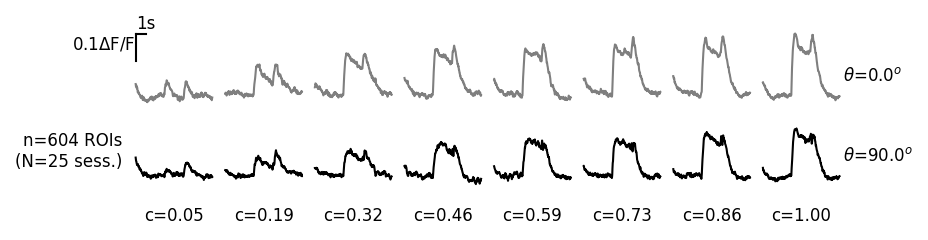

In [6]:
fig, AX = pt.figure(axes=(len(contrasts), len(orientations)), figsize=(.8,.8),wspace=0.1,hspace=0.1)

COLORS = ['tab:grey', 'k']


for o, orientation in enumerate(DATASET['orientations']):
    
    for c, contrast in enumerate(DATASET['contrasts']):

        allResps = np.concatenate([DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['resp']\
                                   for f in range(DATASET['nSessions'])])
        pt.plot(DATASET['t'], 
                np.mean(allResps, axis=0), 
                #sy=np.std(allResps, axis=0),
                #sy=scipy.stats.sem(allResps, axis=0),
                color=COLORS[o], ax=AX[o][c])
        
        AX[o][c].axis('off')
        
pt.annotate(AX[-1][0], '   \nn=%i ROIs \n(N=%i sess.) ' % (np.sum(DATASET['nROIs']),
                                                          DATASET['nSessions']),
           (-0.05,1), va='top', ha='right', color=COLORS[o])
    
for c, contrast in enumerate(DATASET['contrasts']):
    pt.annotate(AX[-1][c], '\nc=%.2f' % contrast, (0.5,0.), va='top', ha='center')
for o, orientation in enumerate(DATASET['orientations']):
    pt.annotate(AX[o][-1], '\n$\\theta$=%.1f$^o$' % orientation, (1,0.8), va='top')
        
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], Xbar=1, Xbar_label='1s', Ybar=0.1, Ybar_label='0.1$\Delta$F/F')

#fig.savefig(os.path.expanduser('~'), 'Desktop', 'fig.svg')

## Summary analysis

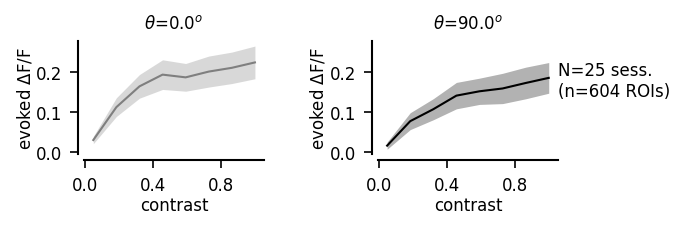

In [17]:
fig, AX = pt.figure(axes=(len(orientations), 1), figsize=(1.2,1.2))

COLORS = ['tab:grey', 'k']

    
for o, orientation in enumerate(DATASET['orientations']):

    allResps = np.array([[np.mean(DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-ROIS'])\
                               for f in range(DATASET['nSessions'])]\
                                for c in range(len(contrasts))])
    pt.plot(contrasts, np.mean(allResps, axis=1), 
            #sy=np.std(allResps, axis=0),
            sy=scipy.stats.sem(allResps, axis=1),
            color=COLORS[o], ax=AX[o])
    pt.set_plot(AX[o], xlabel='contrast', ylabel='evoked $\Delta$F/F', title='$\\theta$=%.1f$^o$' % orientation)
        
pt.set_common_ylims(AX)
pt.annotate(AX[1], '   \nN=%i sess. \n(n=%i ROIs) ' % (DATASET['nSessions'], np.sum(DATASET['nROIs'])),
           (1,1), va='top', color=COLORS[o])

#fig.savefig(os.path.expanduser('~'), 'Desktop', 'fig.svg')

## Show Example ROIs responses

In [29]:
from physion.dataviz.episodes.trial_average import plot as plot_trial_average


def cell_sensitivity_example_fig(filename,
                                 angle=0,
                                stat_test_props = dict(interval_pre=[-1,0], 
                                                       interval_post=[1,2],
                                                       test='ttest',
                                                       positive=True),
                                response_significance_threshold = 0.01,
                                Nsamples = 10, # how many cells we show
                                seed=10):
    
    np.random.seed(seed)
    
    data = physion.analysis.read_NWB.Data(filename)
    
    EPISODES = physion.analysis.process_NWB.EpisodeData(data,
                           quantities=['dFoF'],
                           protocol_id=np.flatnonzero(['8contrasts' in p for p in data.protocols]),
                           with_visual_stim=True,
                           verbose=True)
    
    fig, AX = pt.plt.subplots(Nsamples, len(EPISODES.varied_parameters['contrast']), 
                          figsize=(7,7))
    plt.subplots_adjust(right=0.75, left=0.1, top=0.97, bottom=0.05, wspace=0.1, hspace=0.8)
    
    for Ax in AX:
        for ax in Ax:
            ax.axis('off')

    for i, r in enumerate(np.random.choice(np.arange(data.nROIs), 
                                           min([Nsamples, data.nROIs]), replace=False)):

        # SHOW trial-average
        plot_trial_average(EPISODES,
                           condition=(EPISODES.angle==angle),
                           column_key='contrast',
                           #color_key='contrast',
                           #color=['lightgrey', 'k'],
                           quantity='dFoF',
                           Ybar=1., Ybar_label='1dF/F',
                           Xbar=1., Xbar_label='1s',
                           roiIndex=r,
                           with_stat_test=True,
                           stat_test_props=stat_test_props,
                           with_screen_inset=True,
                           AX=[AX[i]], no_set=False)
        AX[i][0].annotate('roi #%i  ' % (r+1), (0,0), ha='right', xycoords='axes fraction')

        # SHOW summary angle dependence
        inset = pt.inset(AX[i][-1], (2.2, 0.2, 1.2, 0.8))

        contrasts, y, sy, responsive_contrasts = [], [], [], []
        responsive = False

        for c, contrast in enumerate(EPISODES.varied_parameters['contrast']):

            stats = EPISODES.stat_test_for_evoked_responses(episode_cond=\
                                            EPISODES.find_episode_cond(key=['angle', 'contrast'],
                                                                       value=[angle, contrast]),
                                                            response_args=dict(quantity='dFoF', roiIndex=r),
                                                            **stat_test_props)

            contrasts.append(contrast)
            y.append(np.mean(stats.y-stats.x))    # means "post-pre"
            sy.append(np.std(stats.y-stats.x))    # std "post-pre"

            if stats.significant(threshold=response_significance_threshold):
                responsive = True
                responsive_contrasts.append(contrast)

        pt.scatter(contrasts, np.array(y), sy=np.array(sy), ax=inset, ms=1, lw=1)
        inset.plot(contrasts, 0*np.array(contrasts), 'k:', lw=0.5)
        inset.set_ylabel('$\delta$ $\Delta$F/F     ', fontsize=7)
        inset.set_xticks([0,1])
        #inset.set_xticklabels(['%i'%a if (i%2==0) else '' for i, a in enumerate(contrasts)], fontsize=7)
    inset.set_xlabel('contrast', fontsize=7)

        
    return fig

NWB-file reading time: 104.7ms
  Number of episodes over the whole recording: 240/240 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
  -> [ok] episodes ready !


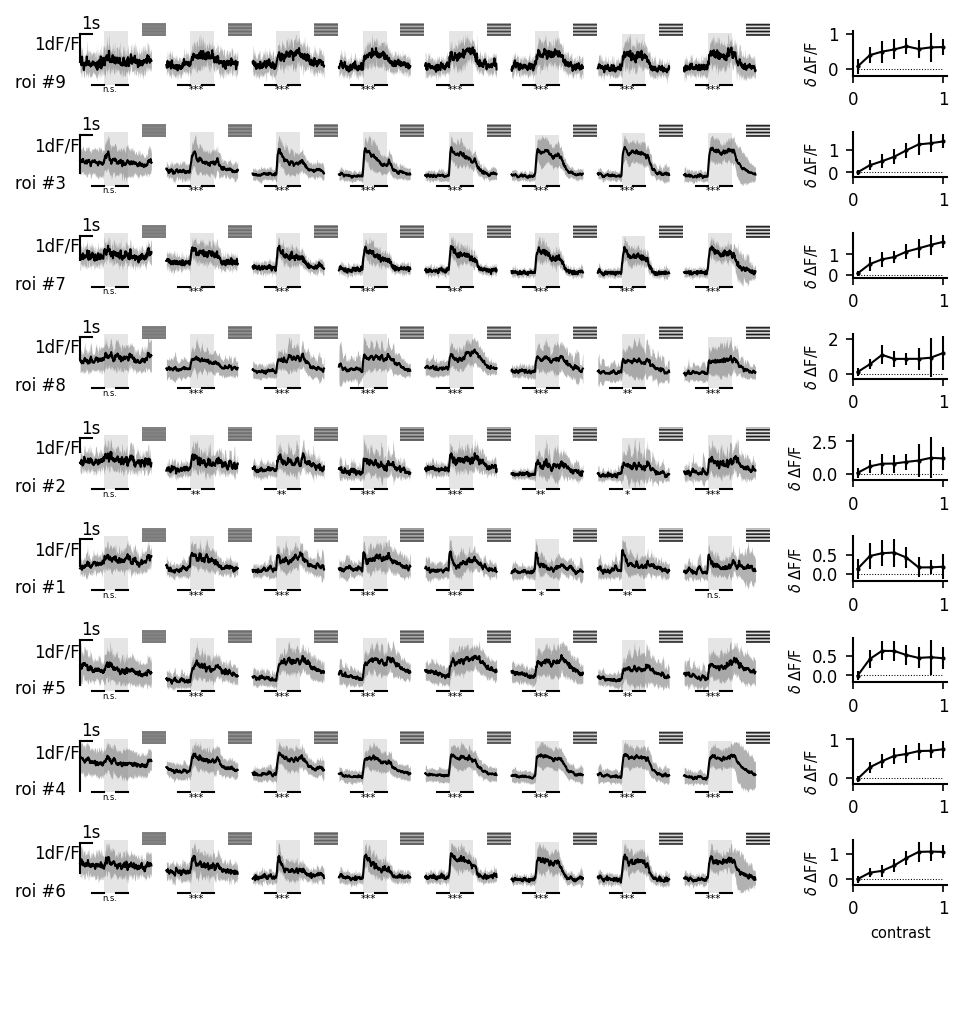

In [30]:
fig = cell_sensitivity_example_fig(DATASET['files'][1], angle=90)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg')

NWB-file reading time: 69.3ms
  Number of episodes over the whole recording: 238/240 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
  -> [ok] episodes ready !


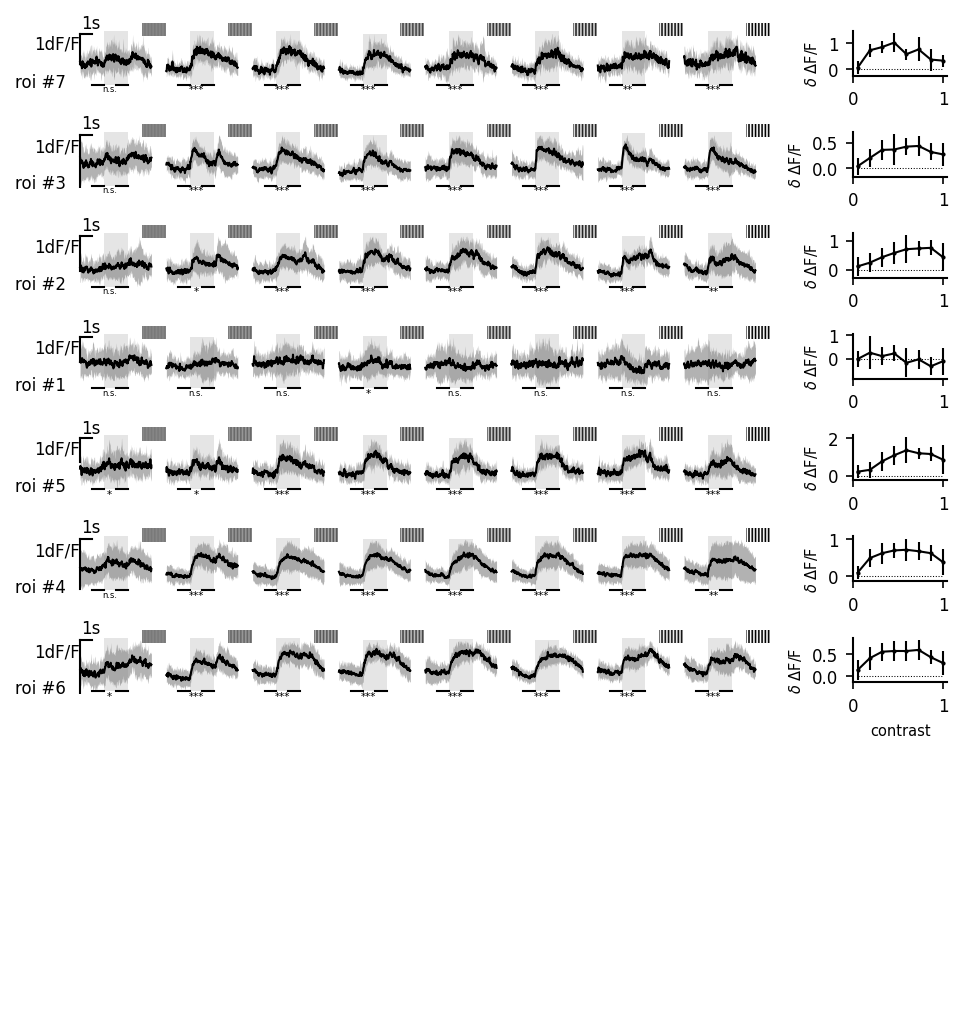

In [31]:
fig = cell_sensitivity_example_fig(DATASET['files'][0], angle=0)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg')